In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
with open("datasets/cifar-10-batches-py/data_batch_1", "rb") as input_file:
    X = pickle.load(input_file, encoding="latin1")

In [3]:
X = X["data"]

In [4]:
X.shape

(10000, 3072)

In [5]:
X = X.reshape((-1, 3, 32, 32))

X.shape

(10000, 3, 32, 32)

In [6]:
X = X.transpose(0, 2, 3, 1)
X.shape

(10000, 32, 32, 3)

In [7]:
X = X.reshape(-1, 3 * 32 * 32)
X.shape

(10000, 3072)

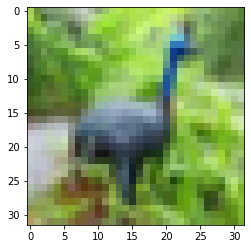

In [8]:
plt.imshow(X[6].reshape(32, 32, 3))

plt.show()

In [9]:
X = X - X.mean(axis=0)

In [10]:
X = X / np.std(X, axis=0)

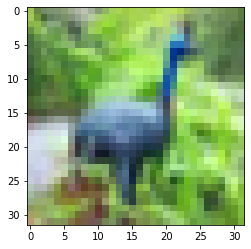

In [11]:
def show(i):
    i = i.reshape((32, 32, 3))

    m, M = i.min(), i.max()

    plt.imshow((i - m) / (M - m))
    plt.show()


show(X[6])

In [12]:
X_subset = X[:1000]

X_subset.shape

(1000, 3072)

In [13]:
cov = np.cov(X_subset, rowvar=True)

In [14]:
cov.shape

(1000, 1000)

In [15]:
U, S, V = np.linalg.svd(cov)

In [16]:
print(U.shape)
print(S.shape)
print(V.shape)

(1000, 1000)
(1000,)
(1000, 1000)


In [17]:
epsilon = 1e-5

zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

In [18]:
zca_matrix.shape

(1000, 1000)

In [19]:
zca = np.dot(zca_matrix, X_subset)

In [20]:
zca.shape

(1000, 3072)

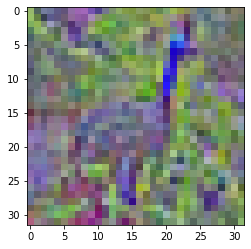

In [21]:
show(zca[6])

In [22]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [23]:
transform = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])

In [24]:
dataset = torchvision.datasets.CIFAR10(
    root="./datasets/cifar10/train", download=True, transform=transform
)

Files already downloaded and verified


In [25]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [26]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2
)

In [27]:
images_batch, labels_batch = iter(dataloader).next()

In [28]:
images_batch.shape

torch.Size([16, 3, 256, 256])

In [29]:
labels_batch.shape

torch.Size([16])

In [30]:
labels_batch

tensor([6, 8, 6, 2, 5, 2, 8, 8, 3, 2, 7, 3, 8, 6, 4, 5])

In [31]:
img = torchvision.utils.make_grid(images_batch)

In [32]:
img.shape

torch.Size([3, 518, 2066])

In [33]:
img = np.transpose(img, (1, 2, 0))

In [34]:
img.shape

torch.Size([518, 2066, 3])

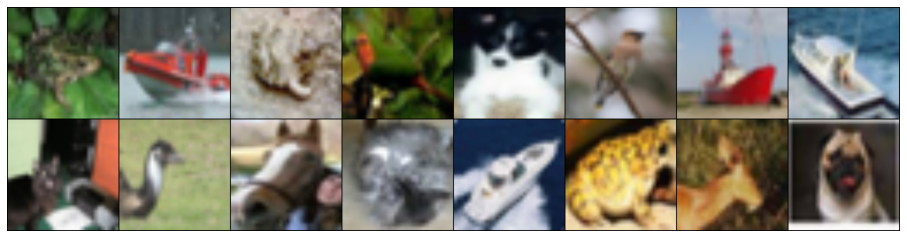

In [35]:
plt.figure(figsize=(16, 22))

plt.imshow(img)
plt.axis("off")
plt.show()

In [36]:
pop_mean = []
pop_std = []

In [37]:
for i, data in enumerate(dataloader, 0):

    numpy_image = data[0].numpy()

    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))

    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [38]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

In [39]:
pop_mean.shape, pop_std.shape

((3125, 3), (3125, 3))

In [40]:
pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

In [41]:
print(pop_mean)
print(pop_std)

[0.4915909 0.4823458 0.4467193]
[0.23832326 0.23488124 0.25267875]


In [42]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std),
    ]
)

In [43]:
trainset = torchvision.datasets.CIFAR10(
    root="./datasets/cifar10/train", train=True, download=True, transform=transform
)

Files already downloaded and verified


In [44]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=2
)

In [45]:
images_batch, labels_batch = iter(trainloader).next()

In [46]:
images_batch.shape

torch.Size([16, 3, 224, 224])

In [47]:
img = torchvision.utils.make_grid(images_batch)
img.shape

torch.Size([3, 454, 1810])

In [48]:
img = np.transpose(img, (1, 2, 0))

img.shape

torch.Size([454, 1810, 3])

In [49]:
m, M = img.min(), img.max()
m, M

(tensor(-2.0627), tensor(2.2039))

In [50]:
img = (1 / (abs(m) * M)) * img + 0.5

In [51]:
img

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5132, 0.5220, 0.4798],
         ...,
         [0.3612, 0.3898, 0.5037],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        ...,

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.6218, 0.5624, 0.4184],
         ...,
         [0.7267, 0.7571, 0.7837],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.

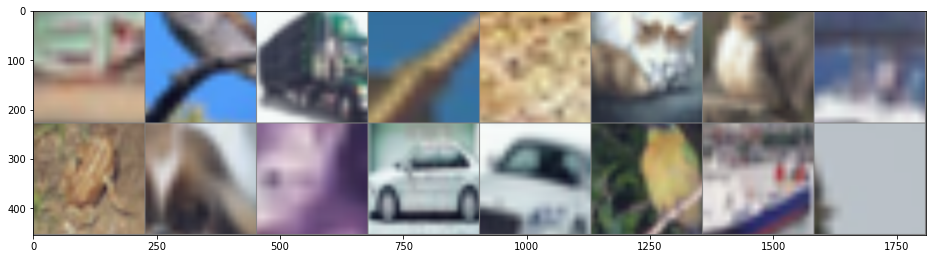

In [52]:
plt.figure(figsize=(16, 12))

plt.imshow(img)
plt.show()